<a href="https://colab.research.google.com/gist/rsavaris66/eccfc6caf4c9578d676c134fac74d3fe/savariscovid_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

In [ ]:
from google.colab import files

uploaded = files.upload()



Saving CovidSavaris.xlsx to CovidSavaris.xlsx


In [ ]:
import numpy as np
import math

In [ ]:
df = pd.read_excel('CovidSavaris.xlsx')
df.columns

Index(['location', 'epi-week', 'date', 'Stay-at-home',
       'new_deaths_per_million'],
      dtype='object')

In [ ]:
location = df['location'][0]
epiweek = df['epi-week'][0]
primeirasemana = df['epi-week'][0]
sum_of_death_million_epi_week = 0.0
mean_stay_at_home_epi_week = 0.0

smooth_death_M = 0.0
smooth_stay_at_home = 0.0

cont = 0

for i in range(df.shape[0]):
    
    #When the week or the country changes, the totals are save as new columns in the last line of the epi-week
    if (df['epi-week'][i] != epiweek or df['location'][i] != location):
        if (df['location'][i] != location):              
            primeirasemana = df['epi-week'][i]                   
        
        df.loc[i - 1, 'sum of death/million/epi-week'] = sum_of_death_million_epi_week
        df.loc[i - 1, 'mean stay-at-home/epi-week'] = mean_stay_at_home_epi_week / cont
        
        #Smooth Death/M and Smooth Stay-at-Home cannot be calculated in the first week of the country 
        if (epiweek > (primeirasemana)):
            df.loc[i - 1, 'Smooth Death/M', ] = sum_of_death_million_epi_week - smooth_death_M     
            df.loc[i - 1, 'Smooth Stay-at-Home'] = (mean_stay_at_home_epi_week / cont) - smooth_stay_at_home 
        
         
        smooth_death_M = sum_of_death_million_epi_week
        smooth_stay_at_home = mean_stay_at_home_epi_week / cont
        
        sum_of_death_million_epi_week = 0.0
        mean_stay_at_home_epi_week = 0.0
        cont = 0
        location = df['location'][i]
        epiweek = df['epi-week'][i]          
    
    #Total values per day and ignore when value is not given
    if (math.isnan(float(df.loc[i, 'new_deaths_per_million'])) == False):
        sum_of_death_million_epi_week += float(df.loc[i, 'new_deaths_per_million'])
    if (math.isnan(float(df.loc[i, 'Stay-at-home'])) == False):
        mean_stay_at_home_epi_week += float(df.loc[i, 'Stay-at-home'])        
        cont += 1

df.loc[i, 'sum of death/million/epi-week'] = sum_of_death_million_epi_week 
df.loc[i, 'mean stay-at-home/epi-week'] = mean_stay_at_home_epi_week / cont
if (smooth_death_M > 0):
    df.loc[i, 'Smooth Death/M', ] = sum_of_death_million_epi_week - smooth_death_M 

if (smooth_stay_at_home > 0):
    df.loc[i, 'Smooth Stay-at-Home'] = (mean_stay_at_home_epi_week / cont) - smooth_stay_at_home     

# Save results in the file
df.to_excel(r'CovidSavaris_Python.xlsx')

In [ ]:
df = pd.read_excel('CovidSavaris_Python.xlsx')
df['mean stay-at-home/epi-week'].notnull()

0        False
1        False
2        False
3        False
4        False
         ...  
16438    False
16439    False
16440    False
16441    False
16442     True
Name: mean stay-at-home/epi-week, Length: 16443, dtype: bool

In [ ]:
#Read the data generated in the previous section
df = pd.read_excel('CovidSavaris_Python.xlsx')
# Remove blank lines in the column "mean stay-at-home/epi-week", leaving just the mean of the epidemiologic week  
df_dadossemana = df[df['mean stay-at-home/epi-week'].notnull()]
df_dadossemana.iloc[:, 2:]

,epi-week,date,Stay-at-home,new_deaths_per_million,sum of death/million/epi-week,mean stay-at-home/epi-week,Smooth Death/M,Smooth Stay-at-Home
6,8,2020-02-22,0.0,0.000,0.000,-0.285714,NaN,NaN
13,9,2020-02-29,1.0,0.000,0.000,1.571429,0.000,1.857143
20,10,2020-03-07,1.0,0.000,0.000,-0.571429,0.000,-2.142857
27,11,2020-03-14,7.0,0.022,0.044,0.571429,0.044,1.142857
34,12,2020-03-21,28.0,0.000,0.022,15.428571,-0.022,14.857143
...,...,...,...,...,...,...,...,...
16414,30,2020-07-25,21.0,0.008,0.064,9.285714,0.040,3.000000
16421,31,2020-08-01,7.0,0.008,0.104,6.571429,0.040,-2.714286
16428,32,2020-08-08,7.0,0.047,0.261,5.857143,0.157,-0.714286
16435,33,2020-08-15,18.0,0.103,0.364,11.857143,0.103,6.000000


In [ ]:
import statsmodels.api as sm
#Select all countries and regions from the dataframe
locations = df_dadossemana['location'].unique()
tabelacompleta = pd.DataFrame()
linha = 0
df.dropna()
#Makes the interaction among regions
for i in locations:
    df_paisum = df_dadossemana[df_dadossemana['location'] == i].reset_index()
    
    #Se eu quero selecionar só um país, retirar "#" das linhas 
    #if (i != 'Canada'):
    #    continue
    
    #For each country, compare to all others
    for j in locations:        
        
        #if (j != 'Australia'):
        #    continue
        
        #Do not compare a region to itself
        if (i == j):
            continue
            
        df_paisdois = df_dadossemana[df_dadossemana['location'] == j].reset_index()         
        tabela = pd.DataFrame()

        #Create a table with all epidemiological weeks
        for k in range(df_paisdois.shape[0]):            
            
            #Subtract death from region A from region B
            tabela.loc[k, '(' + df_paisum['location'][k] + ' - ' + df_paisdois['location'][k] + ') Death'] = float(df_paisum['Smooth Death/M'][k]) - float( df_paisdois['Smooth Death/M'][k])            
            
            #Subtrai o Stay at Home do pais A pelo pais B
            tabela.loc[k, '(' + df_paisum['location'][k] + ' - ' + df_paisdois['location'][k] + ') Stay'] = float(df_paisum['Smooth Stay-at-Home'][k]) - float( df_paisdois['Smooth Stay-at-Home'][k])
            
            #tabela.loc[k, df_paisum['location'][k] + ' Death'] = df_paisum['Smooth Death/M'][k]            
            #tabela.loc[k, df_paisdois['location'][k] + ' Death'] = df_paisdois['Smooth Death/M'][k]            
            #tabela.loc[k, '(' + df_paisum['location'][k] + ' - ' + df_paisdois['location'][k] + ') Death'] = float(df_paisum['Smooth Death/M'][k]) - float( df_paisdois['Smooth Death/M'][k])            
            #tabela.loc[k, '(' + df_paisum['location'][k] + ' - ' + df_paisdois['location'][k] + ') Stay'] = float(df_paisum['Smooth Stay-at-Home'][k]) - float( df_paisdois['Smooth Stay-at-Home'][k])            
            #tabela.loc[k, df_paisum['location'][k] + ' Stay'] = df_paisum['Smooth Stay-at-Home'][k]            
            #tabela.loc[k, df_paisdois['location'][k] + ' Stay'] = df_paisdois['Smooth Stay-at-Home'][k]            
            #print('{0} {1} {2}'.format(float(df_paisum['Smooth Stay-at-Home'][k]) , float( df_paisdois['Smooth Stay-at-Home'][k]), float(df_paisum['Smooth Stay-at-Home'][k]) - float( df_paisdois['Smooth Stay-at-Home'][k])))
            
        #Ignore the 8th week    
        tabela = tabela.dropna()
        X = tabela.iloc[:, 1:2].values # Stay
        x = sm.add_constant(X) #
        y = tabela.iloc[:, 0:1] # (Argentina - Australia) Death 
        res = sm.OLS(y,x).fit() #Create and adjust the model
        
        #Generate the tables with statistical values obtaiend from the comparison
        tabelacompleta.loc[linha, 'Location_A'] = df_paisum['location'][1]
        tabelacompleta.loc[linha, 'Location_B'] = df_paisdois['location'][1]
        tabelacompleta.loc[linha, 'A Death - B Death'] =  df_paisum['location'][1] + ' - ' + df_paisdois['location'][1]
        tabelacompleta.loc[linha, 'p_const'] = res.pvalues[0]
        tabelacompleta.loc[linha, 'p_x1'] = res.pvalues[1]
        tabelacompleta.loc[linha, 'coef_const'] = res.params[0]
        tabelacompleta.loc[linha, 'coef_x1'] = res.params[1]
        tabelacompleta.loc[linha, 'rsquared'] = res.rsquared    
        tabelacompleta.loc[linha, 'rsquared_adj'] = res.rsquared_adj 
        linha += 1
tabelacompleta.to_excel(r'Regression.xlsx')        

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#Read the data generated from previous step
tabelacompleta = pd.read_excel('Regression.xlsx')
#Ordena pelo menor valor de p
tabOrdenada = tabelacompleta.sort_values(by=['p_x1']).reset_index()    
for i in range(tabelacompleta.shape[0]):
    #Calculate the FDR(False  DiscoveryRate) by Benjamini  &  Hochberg         
    if (int(tabOrdenada.shape[0]) - (i + 1) > 0):
        tabOrdenada.loc[i, 'FDR B-H'] = float(tabOrdenada['p_x1'][i]) * (int(tabOrdenada.shape[0]) /(int(tabOrdenada.shape[0]) - (i + 1)))

#List from small to big    
tabelacompleta = tabOrdenada.sort_values(by=['A Death - B Death']).reset_index()        
# Week 9   
# Get -0.0398
# p 0.6
#Save the result in Excel 
tabelacompleta.iloc[:,3:].to_excel(r'Regression_FDR.xlsx')

In [ ]:
tabelacompleta.head(10)

,level_0,index,Unnamed: 0,Location_A,Location_B,A Death - B Death,p_const,p_x1,coef_const,coef_x1,rsquared,rsquared_adj,FDR B-H
0,4676,0,0,Argentina,Australia,Argentina - Australia,0.004260,0.641292,0.824354,-0.039775,0.009192,-0.032092,1.710570
1,424,1,1,Argentina,Austria,Argentina - Austria,0.051814,0.055669,1.186947,-0.409690,0.144226,0.108568,0.059022
2,5196,2,2,Argentina,Bahrain,Argentina - Bahrain,0.302319,0.712108,0.710243,0.076579,0.005777,-0.035649,2.331725
3,769,3,3,Argentina,Belarus,Argentina - Belarus,0.053085,0.108026,0.767722,0.123737,0.104043,0.066711,0.120419
4,4734,4,4,Argentina,Belgium,Argentina - Belgium,0.816565,0.648768,1.096698,-0.863872,0.008787,-0.032514,1.767047
5,6957,65,65,Argentina,Belo Horizonte,Argentina - Belo Horizonte,0.664527,0.926461,-0.542945,-0.063996,0.000362,-0.041289,13.228592
6,4996,82,82,Argentina,Berlin,Argentina - Berlin,0.165501,0.684282,0.909379,0.109434,0.007010,-0.034365,2.060280
7,4107,5,5,Argentina,Bosnia and Herzegovina,Argentina - Bosnia and Herzegovina,0.442544,0.559532,0.415666,-0.165665,0.014382,-0.026685,1.240787
8,6424,6,6,Argentina,Bulgaria,Argentina - Bulgaria,0.035542,0.853362,0.761718,-0.022294,0.001452,-0.040154,6.040540
9,4201,7,7,Argentina,Canada,Argentina - Canada,0.369790,0.576912,0.826420,0.241768,0.013154,-0.027964,1.315993


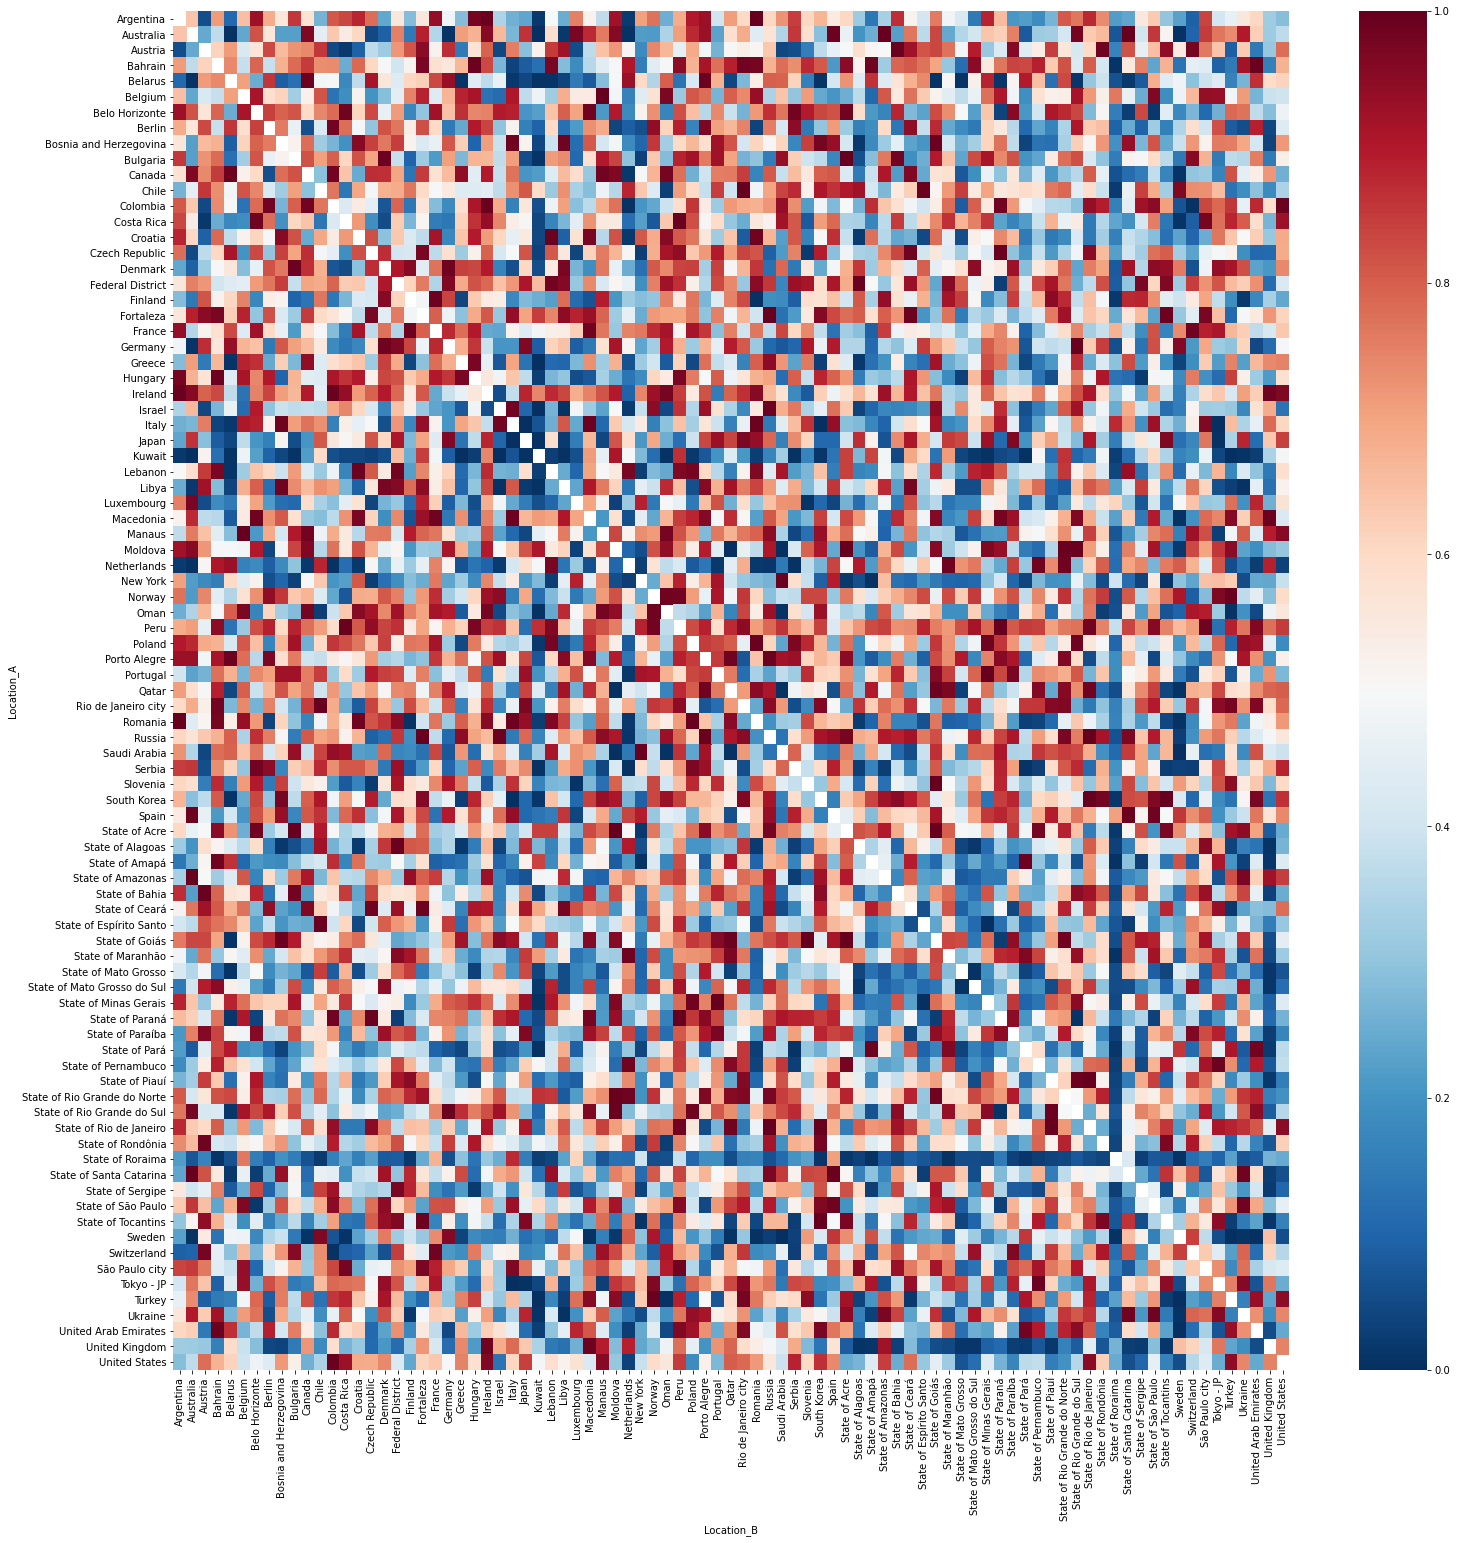

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO

#Height and lenght of the figure
plt.figure(figsize=(25,25))

tabelacompleta = pd.read_excel('Regression_FDR.xlsx')

dados = tabelacompleta.pivot("Location_A", "Location_B", "p_x1")

fig = sns.heatmap(dados, robust=True, fmt="f", cmap='RdBu_r', vmin=0, vmax=1)

plt.savefig('heatmap_PDF.pdf', format='pdf')

In [ ]:
dados.to_excel('DadosPivot.xlsx')